In [1]:
%cd NLP_RL_Docker_Version/

/NLP_RL_Docker_Version


### CAREFUL

In [ ]:
# !rm -rf results/
!mkdir results

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease -1 --log 20

In [3]:
import sys 
sys.path.append('/NLP_RL_Docker_Version/gym-examples')
import gym 
import model as M
import model_nlp as MNLP
import utils as U
import torch
import copy
import gym_examples
suffix = [['easy','medium','hard','naive'],['fnlp_easy','fnlp_medium','fnlp_hard','fnlp_naive']]

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import json 
import matplotlib.pyplot as plt 

def plot_ppo(name):
    arr=[]
    with open(f'results/test_reward_list_{name}.json', 'r') as file:
        arr=json.load(file)
        x,y=[arr[i][0] for i in range(len(arr))], [arr[i][1] for i in range(len(arr))]
        plt.plot(x,y)
        plt.xlabel(f'Frame Number')
        plt.ylabel(f'Cumulative Reward')
        plt.show()

In [5]:
def run_best_env(number,name):
    str_arr = name.split('_')
    opt = 0
    if 'fnlp' in str_arr:
        opt = 1
    def policy(S):
        nonlocal opt 
        if opt == 0:
            dist, value = model(S['visual'])
        elif opt == 1:
            dist, value = model(S['visual'],S['text'])
        action = dist.sample()
        return action.cpu().numpy().item()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if opt == 0:
        model = M.NNModel().to(device)
    elif opt == 1:
        model = MNLP.NNModelNLP().to(device)
    model.load_state_dict(torch.load(f'results/model_{name}.ml'))
    dbg=True 
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number,seed=42)
        state = copy.deepcopy(observation)
        observation['state'] = U.pre_process(observation)
        if opt == 1:
            observation['text'] = U.pre_process_text(model,observation)
        while True:
            print(observation['text'])
            if dbg==True:
                plt.imshow(state['visual'])
                plt.show()
            action = policy(observation)  # User-defined policy function
            observation, reward, terminated, info = env.step(action)
            print(f'Action {action}')
            state = copy.deepcopy(observation)
            observation['state'] = U.pre_process(observation)
            if opt == 1:
                observation['text'] = U.pre_process_text(model,observation)
            cumulative_reward += reward
            steps += 1
            if terminated: break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

In [ ]:
plot_ppo(suffix[0][-1])
run_best_env(1,suffix[0][-1])

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease -1 --iter 500

In [ ]:
plot_ppo(suffix[1][-1])
run_best_env(1,suffix[1][-1])

### Best Agent

In [10]:
def best_env(number=1):
    f,s,t = number//100,(number%100)//10,number%10
    exp_action = [0,3]*f + [1,4]*s + [2,5]*t
    exp_action_indx = 0
    def human_policy(observation):
        nonlocal exp_action_indx
        # action=int(input())
        try:
            action = exp_action[exp_action_indx]
            exp_action_indx += 1
        except Exception as e:
            action = -1
        return action
    dbg=True 
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number)
        cnt,mx_iter=0,1002
        while steps<mx_iter:
            print(observation['text'])
            if dbg==True:
                plt.imshow(observation['visual'])
                plt.show()
            action = human_policy(observation)  # User-defined policy function
            print(action)
            observation, reward, terminated, info = env.step(action)
            cumulative_reward+=reward
            steps+=1
            if dbg==True:
                print(f'cumulative_reward {cumulative_reward}; action {action}')
            if terminated:
                break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


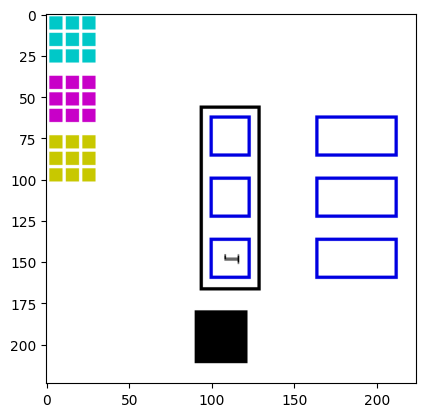

2
cumulative_reward 1; action 2
Put the unit block in the unit's palce .


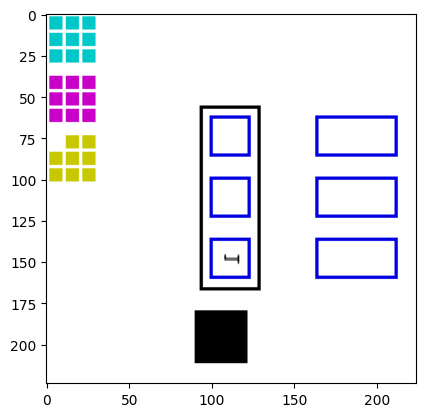

2
cumulative_reward -1; action 2
Put the unit block in the unit's palce .


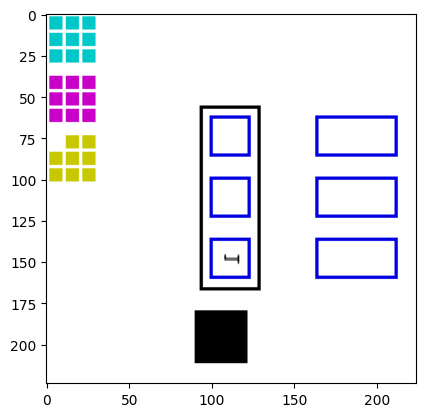

2
cumulative_reward -3; action 2
Put the unit block in the unit's palce .


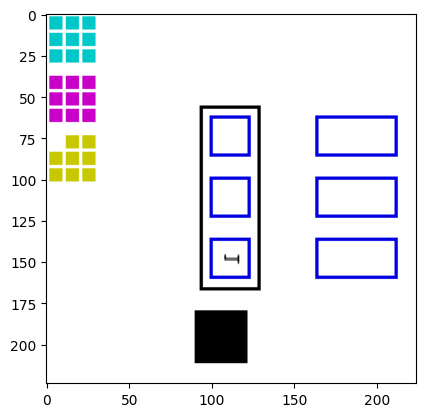

2
cumulative_reward -5; action 2
Put the unit block in the unit's palce .


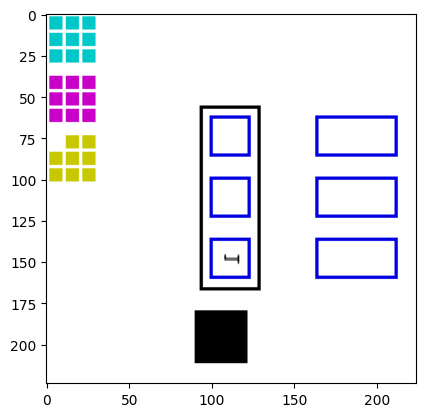

2
cumulative_reward -7; action 2
Put the unit block in the unit's palce .


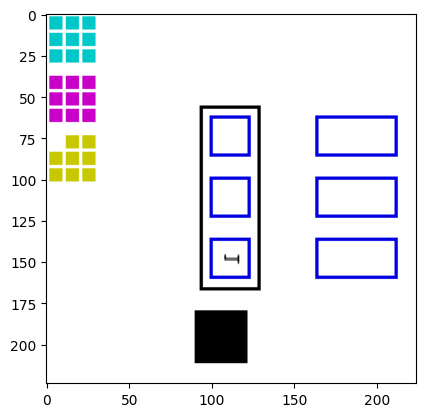

2
cumulative_reward -17; action 2
Cumulative Reward ~ -17; TimeTaken ~ 6


In [11]:
best_env()

## Run more difficult tasks.

In [ ]:
%cd NLP_RL_Docker_Version/

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease 0 --iter 2000

In [ ]:
plot_ppo(suffix[0][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[0][0]) # See the performance on the most difficult number. 

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease 0 --iter 2000

In [ ]:
plot_ppo(suffix[1][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[1][0]) # See the performance on the most difficult number. 